# Отток клиентов

# 1. Подготовка данных

## 1.1. Функции

In [1]:
# импорт необходимых модулей
import warnings
warnings.filterwarnings('ignore')

import sys
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from urllib.parse import urlencode
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

In [2]:
LINK = "https://yadi.sk/d/XayfW9lDkYbsjg"
RANDOM=12345

In [3]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [4]:
def split_data(features, target):
    """
    Функция разбивает данные на 3 выборки: обучающую, валидационную и тестовую
    """
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.4, random_state=RANDOM
    )

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, test_size=0.5, random_state=RANDOM
    )

    print('Done.')
    print(features_train.shape)
    print(features_valid.shape)
    print(features_test.shape)

    return {'features': (features_train, features_valid, features_test),
            'target': (target_train, target_valid, target_test)}

In [5]:
def fit_LG(X_train, y_train, class_weight=None):
    """
    Функция для нахождения подходящих гиперпараметров для LogisticRegression
    X_train - признаки обучающей выборки
    y_train - целевой признак обучающей выборки
    class_weight - взвешивание классов (по-умолчанию None)
    """
    skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM)
    c_values = np.logspace(-5, 5, 500)

    logit_searcher = LogisticRegressionCV(Cs=c_values,
                                          solver='lbfgs',
                                          refit=True,
                                          penalty='l2',
                                          scoring='f1',
                                          max_iter=1000,
                                          class_weight=class_weight,
                                          cv=skf, verbose=1, n_jobs=-1)
    
    logit_searcher.fit(X_train, y_train)
    
    return logit_searcher

In [6]:
def fit_RF(X_train, y_train):
    """
    Функция для нахождения подходящих гиперпараметров для RandomForestClassifier
    X_train - признаки обучающей выборки
    y_train - целевой признак обучающей выборки
    """
    
    # исследуемые параметры
    param_grid = {
        'random_state': [RANDOM,],
        'criterion': ['gini'],
        'max_depth': range(5, 21, 5),
        'max_features': [2, 3],
        'n_estimators': range(90, 120, 10),
        'min_samples_leaf': [5],
        'class_weight': [None, {0:1,1:2}]
    }
    
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, 
                               n_jobs = -1, verbose = 2, scoring='f1')
    grid_search.fit(X_train, y_train)
    best_grid = grid_search.best_estimator_
    
    return best_grid

In [7]:
def get_scores(y_true, y_pred, y_prob):
    """
    Получение значений необходимых метрик качества
    y_true - истиные значения целевого признака
    y_pred - предсказания
    """
    recall = recall_score(y_true, y_pred).round(2)
    precision = precision_score(y_true, y_pred).round(2)
    f1 = f1_score(y_true, y_pred).round(2)
    roc = roc_auc_score(y_true, y_prob).round(2)
    
    return (recall, precision, f1, roc)

In [8]:
def sample_scores(model, label, X, y, plot=False, ax=None):
    """
    Получение метрий для конкретной выборки
    """
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:,1]
    
    recall, precision, f1, roc = get_scores(y, predictions, probabilities)
    
    get_roc_curve(y, probabilities, name=label, ax=ax)
    
    return [recall, precision, f1, roc]

In [9]:
def evaluate(model, X_train, y_train, X_valid, y_valid, suffix='', plot=False):
    """
    Получение значений метрик для модели
    """
    metric_values = {'Score': ['Recall', 'Precision', 'F1', 'AUC ROC']}
    label = '{} {}'.format(type(model).__name__, suffix)
    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    
    # Train sample iteration
    model_label = '{} ({})'.format(label, 'Train')
    metric_values['train'] = sample_scores(model, model_label, X_train, y_train, 
                                           plot=plot, ax=axes[0])
    # Valid sample iteration
    model_label = '{} ({})'.format(label, 'Valid')
    metric_values['valid'] = sample_scores(model, model_label, X_valid, y_valid, 
                                           plot=plot, ax=axes[1])
    plt.show()
    
    metrics_data = pd.DataFrame(metric_values)
    metrics_data.name = model_label
    
    return metrics_data

In [10]:
def get_roc_curve(y_true, y_probs, name='default', ax=None):
    """
    Получение ROC
    """
    check = ax
    title = 'ROC '+name
    
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    
    if not check:
        fig, ax = plt.subplots(figsize=(10,5))
    
    ax.plot(fpr, tpr, color='darkorange', label='ROC curve')
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.title.set_text(title)
    ax.legend(loc="lower right")
    
    if not check:
        plt.show()

In [11]:
def research_models(X_train, y_train, X_valid, y_valid, balanced=False, 
                    plot=False, forest=True):
    """
    Исследование моделей
    """
    class_weight = None
    suffix = ''
    
    if balanced:
        class_weight = 'balanced'
        suffix = 'balanced'
        
    print('\nResearch LG ...\n')
    lg = fit_LG(X_train, y_train, class_weight=class_weight)
    lg_metrics = evaluate(lg, X_train, y_train, X_valid, y_valid, suffix=suffix, plot=plot)
    print(lg_metrics)
    
    if forest:
        print('\nResearch RF ...\n')
        rf = fit_RF(X_train, y_train)
        rf_metrics = evaluate(rf, X_train, y_train, X_valid, y_valid, plot=plot)
        print(rf_metrics)
        
        return (lg, rf)
    
    return lg

In [12]:
def upsample(features, target, repeat):
    """
    Функция увеличения числа выборки.
    features - признаки
    target   - целевая переменная
    repeat   - во сколько раз увеличить
    """
    tname = target.columns[0]
    
    # UPDATE
    # df = features_train.reset_index(drop=True).join(target_train.reset_index(drop=True))
    df = features.reset_index(drop=True).join(target.reset_index(drop=True))
    
    features_zeros = df[df[tname] == 0].drop(columns=[tname])
    features_ones = df[df[tname] == 1].drop(columns=[tname])

    target_zeros = df[df[tname] == 0][[tname]]
    target_ones = df[df[tname] == 1][[tname]]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM)
    
    return features_upsampled, target_upsampled

In [13]:
def downsample(features, target, fraction):
    """
    Функция уменьшения числа выборки.
    features - признаки
    target   - целевая переменная
    repeat   - какую долю класса оставить
    """
    tname = target.columns[0]
    df = features.reset_index(drop=True).join(target.reset_index(drop=True))

    features_zeros = df[df[tname] == 0].drop(columns=[tname])
    features_ones = df[df[tname] == 1].drop(columns=[tname])

    target_zeros = df[df[tname] == 0][[tname]]
    target_ones = df[df[tname] == 1][[tname]]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM)] + [features_ones])
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM)
    
    return features_downsampled, target_downsampled

## 1.2. Ознакомление с данными

In [14]:
data_orig = pd.read_csv(get_url(LINK))

Run https://yadi.sk/d/XayfW9lDkYbsjg


In [15]:
data_orig.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [16]:
data_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<span style="float:left">


|        Признак       |                  Описание                         |         Действия      |
|:---------------------|:--------------------------------------------------|:----------------------|
| _RowNumber_          | индекс строки в данных                            | Удалить               |
| _CustomerId_         | уникальный идентификатор клиента                  | Удалить               |
| _Surname_            | фамилия                                           | Удалить               |
| _Geography_          | страна проживания                                 | Закодировать          |
| _Gender_             | пол                                               | Закодировать          |
| _CreditScore_        | кредитный рейтинг                                 | Исследовать           |
| _Age_                | возраст                                           | Исследовать           |
| _Tenure_             | количество недвижимости у клиента                 | Исследовать           |
| _NumOfProducts_      | количество продуктов банка, используемых клиентом | Исследовать           |
| _HasCrCard_          | наличие кредитной карты                           | Исследовать           |
| _IsActiveMember_     | активность клиента                                | Исследовать           |
| _Balance_            | баланс на счёте                                   | Масштабировать        |
| _EstimatedSalary_    | предполагаемая зарплата                           | Масштабировать        |

</span>

## 1.3. Подготовка данных

Признаки _CustomerId_ , _Surname_ и _RowNumber_ не пригодятся в дальнейшей работе, так как не несут смысловой нагрузки в данной задаче. Удалим их.

In [17]:
data = data_orig.copy()

In [18]:
data = data.drop(['Surname','CustomerId', 'RowNumber'], axis=1)
data.sample(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9315,694,France,Male,42,8.0,133767.19,1,1,0,36405.21,0
8209,706,Germany,Male,32,5.0,88348.43,2,1,1,104181.78,0


Удалим данные с пропусками в _Tenure_ , так как это помешает в дальнейшей работе.

In [19]:
data['Tenure'] = data['Tenure'].fillna(0)
data.Tenure.value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: Tenure, dtype: int64

Подготовим признаки. Заменим признак пола на числовое значение (прямое кодирование).

In [20]:
data = pd.get_dummies(data, columns=['Gender'], drop_first=True)

In [21]:
data.sample(3)

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male
5929,699,France,32,3.0,0.00,2,1,1,170770.44,0,1
5391,639,Spain,27,8.0,133806.54,2,1,0,6251.30,0,0
4385,651,France,35,2.0,86911.80,1,1,0,174094.24,0,1


Обработаем признак _Geography_ порядковым кодированием.

Применяем прямое кодирование.

In [22]:
data = pd.get_dummies(data, columns=['Geography'], drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


## Комментарий наставника
<span style="color:red">Порядковое кодирование — это замечательно, но линейные модели (включая логистическую регрессию) не умеют обрабатывать признаки, закодированные таким образом. Для логистической регрессии тебе нужно будет добавить прямое кодирование признака со страной. Для всех остальных моделей порядковое кодирование подойдет (для случайного леса оно действительно лучше), либо можешь только прямым методом всё закодировать.</span> \
<span style="color:orange">UPD 14.08.2020 Теперь лучше. Зря вызов с **drop_first=True** закомментировала, лучше избавляться от лишнего признака (у нас было бы 2 признака со страной и если в каждом из них в записи стоял бы ноль, это автоматически означало бы, что клиент из  третьей страны, то есть нужды в отдельном третьем признаке нет).</span>

Так как присутствуют признаки, которые значительно отличаются масштабом, проведем Z-преобразование признаков (стандартизацию данных).

In [23]:
features_for_scaling = ['Balance', 'EstimatedSalary', 'CreditScore', 'Age']

In [24]:
data_scaled = data.copy()
scaler = StandardScaler()
scaler.fit(data[features_for_scaling])

# остальное отмасштабируем после разбиения

StandardScaler()

Признаки _Geography_ , _Tenure_ приведем к целочисленному типу.

In [25]:
# data_scaled[['Geography' , 'Tenure']] = data_scaled[['Geography' , 'Tenure']].astype('int')
data_scaled[['Tenure']] = data_scaled[['Tenure']].astype('int')
data_scaled.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


Количественные признаки преобразовали,категориальные - закодировали или оставили как есть.

Определим список признаков и целевую переменную.

In [26]:
data.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Gender_Male',
       'Geography_Germany', 'Geography_Spain'],
      dtype='object')

In [27]:
features_names = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                  'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Gender_Male',
                  'Geography_Germany', 'Geography_Spain']

target_name = ['Exited']

Разделим данные на обучающую, валидационную и тестовую выборки.

In [28]:
split_result = split_data(data_scaled[features_names], data_scaled[target_name])

features_train, features_valid, features_test = split_result['features']

target_train, target_valid, target_test = split_result['target']

Done.
(6000, 11)
(2000, 11)
(2000, 11)


In [29]:
# отмасштабируем выборки
features_train[features_for_scaling] = scaler.transform(features_train[features_for_scaling])
features_valid[features_for_scaling] = scaler.transform(features_valid[features_for_scaling])
features_test[features_for_scaling] = scaler.transform(features_test[features_for_scaling])

## 1.4. Вывод

1. В данных присутствуют числовые и категориальные данные. Лишние категориальные убрали, остальные закодировали в числовых значениях.
*  В признаке _Tenure_ есть пропуски (~10%) - удалили.
*  Разделили данные на 3 выборки.

В работе будем исследовать _Логистическую регрессию_ и _Случайный лес_ .

# 2. Исследование задачи

## 2.1. Исследование баланса классов

Посмотрим на балланс классов в целевой переменной.

In [30]:
exited_data = data_scaled.Exited.value_counts().to_frame().transpose()
exited_sum = exited_data[1] + exited_data[0]
exited_data['0_frac'] = round(exited_data[0] / exited_sum, 2)
exited_data['1_frac'] = round(exited_data[1] / exited_sum, 2)
exited_data

,0,1,0_frac,1_frac
Exited,7963,2037,0.8,0.2


In [31]:
exited_data = data_scaled.Exited.value_counts(normalize=True)
exited_data

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Присутствует дисбаланс классов:
* класс 1 - 20% от общего количества
* класс 0 - 80%

Посмотрим на решение задачи без учета дисбаланса.

## 2.2. Изучение модели без учёта дисбаланса


Research LG ...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


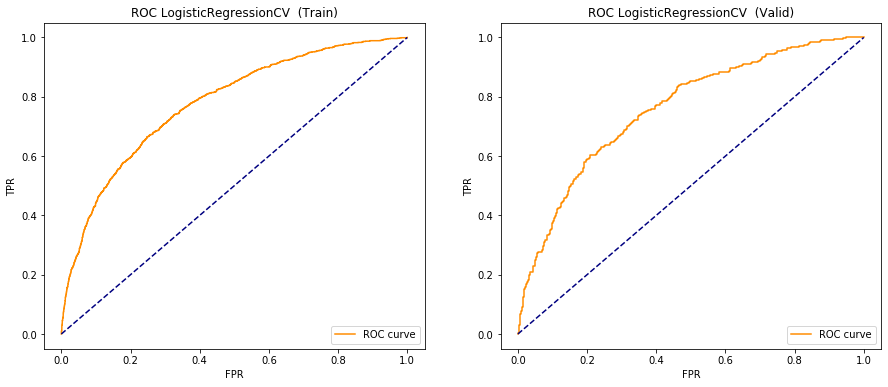

       Score  train  valid
0     Recall   0.24   0.24
1  Precision   0.62   0.57
2         F1   0.35   0.33
3    AUC ROC   0.78   0.76

Research RF ...

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.0min finished


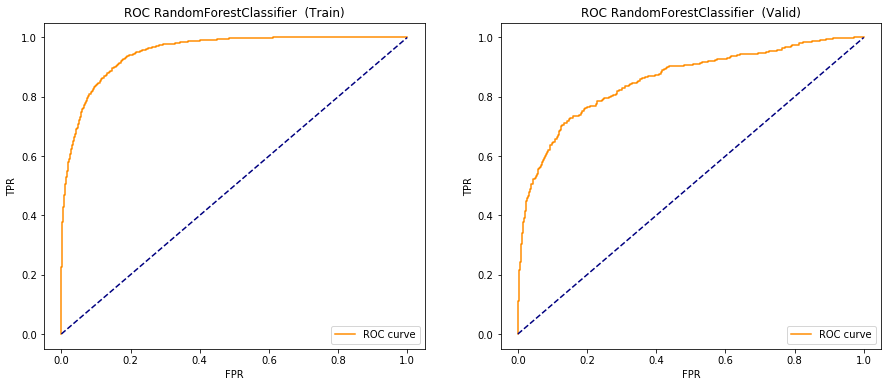

       Score  train  valid
0     Recall   0.65   0.53
1  Precision   0.82   0.72
2         F1   0.73   0.61
3    AUC ROC   0.95   0.86


In [32]:
lg, rf = research_models(features_train, target_train, features_valid, target_valid, plot=False)


Research LG ...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished


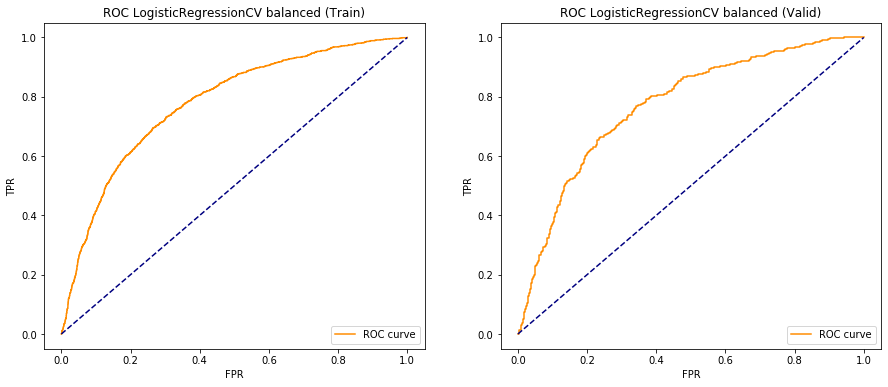

       Score  train  valid
0     Recall   0.70   0.68
1  Precision   0.39   0.40
2         F1   0.50   0.50
3    AUC ROC   0.78   0.77


In [33]:
lg_balanced = research_models(features_train, target_train, features_valid, 
                              target_valid, balanced=True, plot=False,
                              forest=False)

## 2.3. Вывод

Из проведенных экспериментов видно, что положительный класс (т. е. уход клиента из банка) прогнозируются плохо, несмотря на заметное улучшение метрики F1 при взвешивании классов на логистической регрессии. Таким образом имеем значения F1-меры:

<span style="float:left">

| Модель      |   F1   |
|:------------|:------:|
| LG          | 0.33   |
| LG balanced | 0.50   |
| RF          | 0.61   |
</span>

Значения метрики F1 не удовлетворяют требованиям поставленной задачи. Избавимся от дисбаланса классов.

# 3. Борьба с дисбалансом

## 3.1. Увеличение выборки

Получим разницу (во сколько раз по количеству отличаются классы в целевой переменной) и увеличим количество наблюдений для меньшего класса.

In [34]:
repeat = int(round(exited_data[0]/exited_data[1]))
print(repeat)

features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
target_upsampled.Exited.value_counts()

4


0    4804
1    4784
Name: Exited, dtype: int64


Research LG ...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished


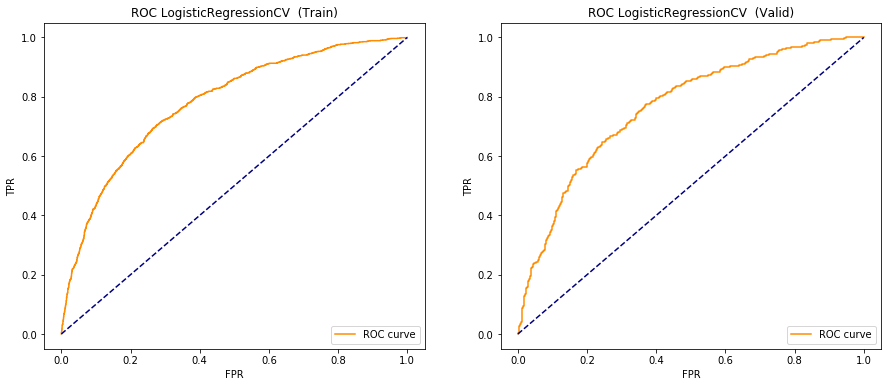

       Score  train  valid
0     Recall   0.71   0.68
1  Precision   0.72   0.38
2         F1   0.71   0.49
3    AUC ROC   0.78   0.76

Research RF ...

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.8min finished


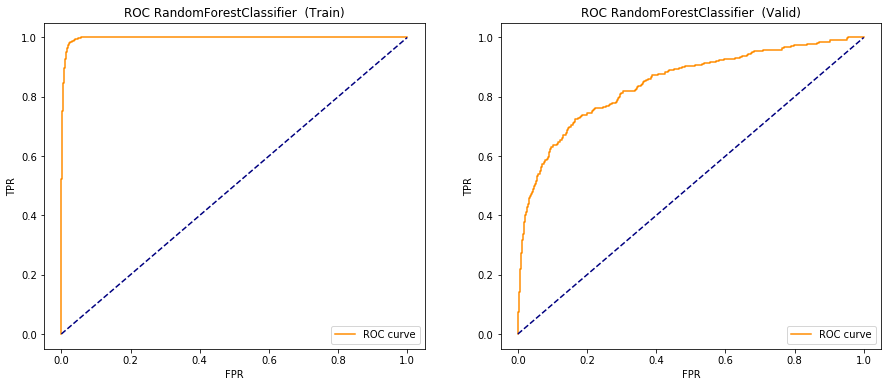

       Score  train  valid
0     Recall   1.00   0.72
1  Precision   0.91   0.52
2         F1   0.95   0.61
3    AUC ROC   1.00   0.85


In [35]:
lg_upsearch, rf_upsearch = research_models(features_upsampled, target_upsampled, 
                                           features_valid, target_valid, plot=True)

## 3.2. Уменьшение  выборки

In [36]:
frac = exited_data[1] / exited_data[0]
frac

0.25580811252040686

In [37]:
features_downsampled, target_downsampled = downsample(features_train, target_train, frac)
features_downsampled.shape

(2425, 11)

In [38]:
target_downsampled.Exited.value_counts()

0    1229
1    1196
Name: Exited, dtype: int64


Research LG ...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished


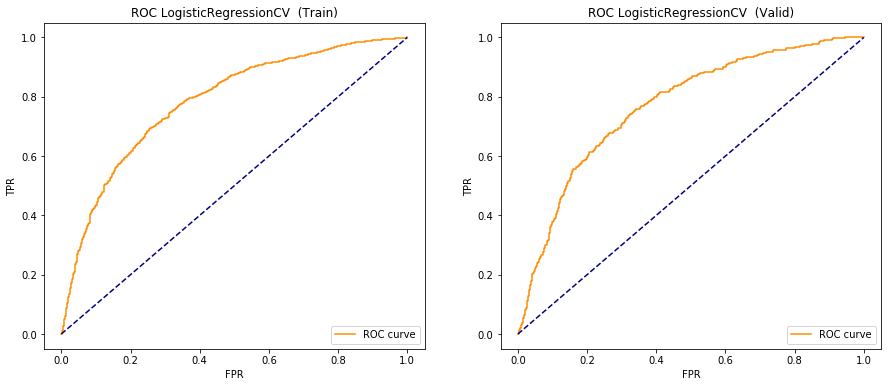

       Score  train  valid
0     Recall   0.69   0.68
1  Precision   0.72   0.40
2         F1   0.71   0.50
3    AUC ROC   0.78   0.77

Research RF ...

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   49.5s finished


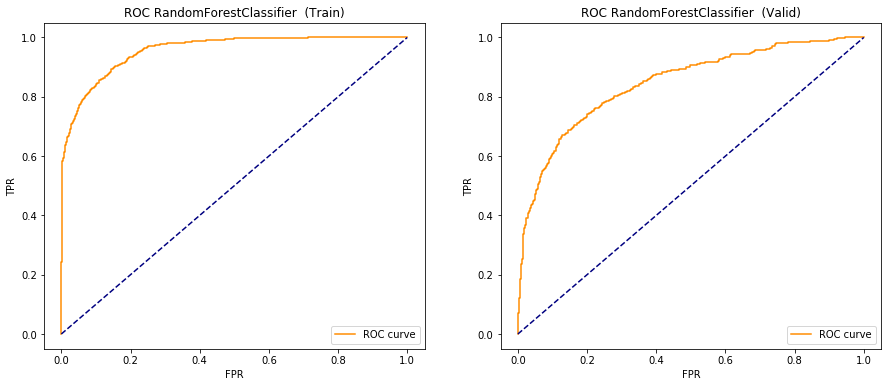

       Score  train  valid
0     Recall   0.95   0.84
1  Precision   0.81   0.39
2         F1   0.87   0.54
3    AUC ROC   0.96   0.85


In [39]:
lg_downsearch, rf_downsearch = research_models(features_downsampled, target_downsampled, 
                                               features_valid, target_valid, plot=True)

## 3.3. Вывод

При увеличении и уменьшении обучающей выборки наблюдается изменение метрики F1:

<span style="float:left">

| Модель          |   F1   |
|:----------------|--------|
| LG upsampled    | 0.45   |
| LG downsampled  | 0.49   |
| RF upsampled    | 0.63   |
| RF downsampled  | 0.59   |
</span>

Проведенное исследование позволяет сделать выбор в пользу модели _Случайный лес_ , обученной на выборке с увеличнием редкого (положительного) класса. Будем использовать для тестирования _rf_upsearch_ .

# 4. Тестирование модели

## 4.1. Тестирование

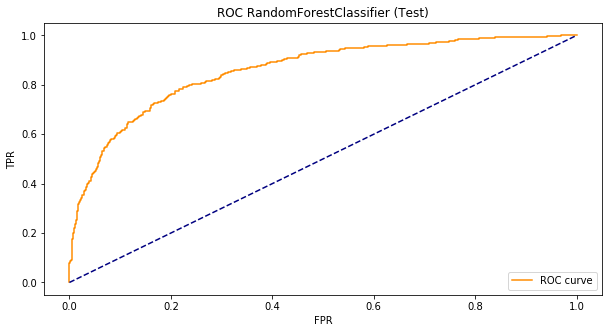

       Score  Test
0     Recall  0.73
1  Precision  0.52
2         F1  0.61
3    AUC ROC  0.86


In [40]:
metric_values = {'Score': ['Recall', 'Precision', 'F1', 'AUC ROC']}
label = type(rf_upsearch).__name__

# Test sample iteration
model_label = '{} ({})'.format(label, 'Test')
metric_values['Test'] = sample_scores(rf_upsearch, model_label,
                                      features_test, target_test,
                                      plot=True)
metrics_data = pd.DataFrame(metric_values)
metrics_data.name = model_label
print(metrics_data)

In [41]:
rf_upsearch.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=20, max_features=3,
                       min_samples_leaf=5, n_estimators=110,
                       random_state=12345)>

## 4.2. Вывод

В результате работы настроена модель, которая позволяет определить уход клиента из банка с точностью > 65%.